In [ ]:
### Step 1. Split reads

import os


work_dir = "/mnt/projects/thiomargarita/samples_data"

for file in os.listdir(work_dir):
    sample_name = file[0:11] # file = sample_name + .fastq
    
    os.system(f"fastq-dump --split-files {sample_name}")
    
    os.system(f"mkdir {work_dir}/{sample_name}")
    os.system(f"mv {work_dir}/{sample_name}*.fastq {work_dir}/{sample_name}")

In [ ]:
### Step 2. Reads quality control before trimming

import os


work_dir = "/mnt/projects/thiomargarita/samples_data"

for sample_name in os.listdir(work_dir):
    for file in os.listdir(os.path.join(work_dir, sample_name)):
        os.system(f"fastqc -t 32 {sample_name}")

In [ ]:
### Step 3. Trimming

import os


work_dir = "/mnt/projects/thiomargarita/samples_data"

for sample_name in os.listdir(work_dir):
    os.system("v2trim"+\ 
              f"-1 {work_dir}/{sample_name}/{sample_name}_1.fastq"+\ 
              f"-2 {work_dir}/{sample_name}/{sample_name}_2.fastq"+\ 
              "-t 32")

In [ ]:
### Step 4. Reads quality control after trimming

'''
moved all raw data in each folder to SRR*/raw
moved all fastqc results in each folder to SRR*/fastqc_results
'''


In [ ]:
### Step 5. Assembly

import os


work_dir = "/mnt/projects/thiomargarita/samples_data"

for sample_name in os.listdir(work_dir):
    os.system(f"spades.py --meta -o {work_dir}/{sample_name}/spades_results"+\ 
              f"-1 {work_dir}/{sample_name}/{sample_name}_trim_1.fastq"+\ 
              f"-2 {work_dir}/{sample_name}/{sample_name}_trim_2.fastq"+\ 
              "-t 32 -k 23,67,99,125")

In [ ]:
### Step 6. Comparison of reads and assemblies

'''
multiqc, quast -l
'''

In [ ]:
### Step 7. Annotation

import os


!export EGGNOG_DATA_DIR=/mnt/projects/users/merirut/software/miniconda3/eggnog-mapper-data
work_dir = "/mnt/projects/thiomargarita/samples_data"

for sample_name in os.listdir(work_dir):
        os.system(f"prokka --outdir {work_dir}/{sample_name}/prokka_results"+\ 
                  f"--prefix {sample_name} --metagenome --locustag gene --cpus 32"+\ 
                  f"{work_dir}/{sample_name}/spades_results/scaffolds.fasta")
        
        os.system(f"emapper.py -i {work_dir}/{sample_name}/prokka_results/{sample_name}.faa"+\ 
                  f"--cpu 32 --output sample_name --output_dir {work_dir}/{sample_name}/emapper_results")

In [ ]:
### Step 8. Extract rRNAs and align them to the reference genome
import os


work_dir = "/mnt/projects/thiomargarita/samples_data"

for sample_name in os.listdir(work_dir):
    os.system(f"barrnap {work_dir}/spades_results/scaffolds.fasta"+\
              f"--threads 32 --outseq {work_dir}/{sample_name}/{sample_name}_rRNAs.fasta")
    
    outfile = f"{work_dir}/{sample_name}/{sample_name}_blast.txt"
    os.system(f"blastn -query {work_dir}/{sample_name}/{sample_name}_rRNAs.fasta"+\ 
              f"-subject {subject_name} -out {outfile}")

In [ ]:
### Step 9. Create "pangenome"

import os


dir = "/mnt/projects/thiomargarita/samples_data"
fasta_file = open("/mnt/projects/thiomargarita/protein_pangenome.fasta", 'w')

for sample_name in os.listdir(dir):
    
    try:
        infile = open(f"{dir}/{sample_name}/prokka_results/{sample_name}.faa", 'r')

        for line in infile:

            if line[0] == '>':
                fasta_file.write('>' + f"{sample_name}_" + line[1::].replace(' ', '_'))

            else:
                fasta_file.write(line)

        infile.close()
    
    except FileNotFoundError:
        pass

fasta_file.close()

In [ ]:
### Step 10. Clustering

!mmseqs easy-cluster protein_pangenome.fasta clustered_pangenome tmp

In [ ]:
### Step 11. Decontamination
### See 'Thiomargarita decontamination.ipynb'

In [2]:
### Step 12. Reassembly using decontaminated reads and check
import os


work_dir = "/mnt/projects/thiomargarita/samples_data"

print("Before decontamination unassembled:")
for sample_name in os.listdir(work_dir):
    if not os.path.exists(f"{work_dir}/{sample_name}/spades_results/scaffolds.fasta"):
        print(sample_name)
        
print("After decontamination unassembled:")
for sample_name in os.listdir(work_dir):
    if not os.path.exists(f"{work_dir}/{sample_name}/decontaminated_reads_assembly/scaffolds.fasta"):
        print(sample_name)

Before decontamination unassembled:
After decontamination unassembled:
SRR18714294
SRR18720393
SRR18720397


In [6]:
### Step 13. Compare QUAST reports for SPAdes assemblies from contaminated and decontaminated reads

import pandas as pd

before = "/mnt/projects/thiomargarita/quast_report.tsv"
after = "/mnt/projects/thiomargarita/quast_report_dec.tsv"

# Load the two TSV files into separate pandas dataframes

df1 = pd.read_csv(before, sep="\t")
df2 = pd.read_csv(after, sep="\t")
before_after = {"Assembly": df1["Assembly"]}

df1 = df1.drop("Assembly", axis=1)
df2 = df2.drop("Assembly", axis=1)

df1 = df1.reindex(sorted(df1.columns), axis=1)
df2 = df2.reindex(sorted(df2.columns), axis=1)

for sample_name in df1.columns:
    column1, column2 = f"{sample_name}_before", f"{sample_name}_after"
    data1, data2 = [], []
    for i in range(22): # QUAST collects 22 parameters
        data1.append(df1[sample_name][i])
        data2.append(df2[sample_name][i])
    before_after[column1] = data1
    before_after[column2] = data2

pd.DataFrame(before_after)

,Assembly,SRR18713657_before,SRR18713657_after,SRR18713668_before,SRR18713668_after,SRR18713683_before,SRR18713683_after,SRR18713684_before,SRR18713684_after,SRR18713715_before,...,SRR18725098_before,SRR18725098_after,SRR18725150_before,SRR18725150_after,SRR18725158_before,SRR18725158_after,SRR18726453_before,SRR18726453_after,SRR18726454_before,SRR18726454_after
0,# contigs (>= 0 bp),1312.00,19.00,152.00,25.00,285.00,104.00,251.0,42.00,615.00,...,21596.00,8079.00,7118.00,6413.00,98146.00,3926.0,1564.00,5.00,4399.00,152.00
1,# contigs (>= 1000 bp),368.00,2.00,7.00,6.00,77.00,14.00,58.0,7.00,199.00,...,3767.00,2258.00,2053.00,2041.00,14722.00,360.0,41.00,2.00,1390.00,8.00
2,# contigs (>= 5000 bp),102.00,0.00,1.00,0.00,17.00,0.00,19.0,0.00,62.00,...,917.00,789.00,699.00,710.00,2153.00,22.0,5.00,0.00,467.00,0.00
3,# contigs (>= 10000 bp),49.00,0.00,1.00,0.00,12.00,0.00,7.0,0.00,32.00,...,450.00,413.00,437.00,441.00,1136.00,7.0,1.00,0.00,276.00,0.00
4,# contigs (>= 25000 bp),5.00,0.00,1.00,0.00,1.00,0.00,0.0,0.00,3.00,...,98.00,97.00,153.00,156.00,394.00,2.0,0.00,0.00,85.00,0.00
5,# contigs (>= 50000 bp),2.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,...,19.00,13.00,43.00,39.00,36.00,0.0,0.00,0.00,15.00,0.00
6,Total length (>= 0 bp),2305045.00,12766.00,84159.00,17702.00,451021.00,66923.00,336593.0,24180.00,1232420.00,...,26004821.00,16506294.00,17752653.00,17405174.00,94302584.00,2478290.0,518615.00,4992.00,10854775.00,113226.00
7,Total length (>= 1000 bp),1855965.00,3015.00,37679.00,9324.00,364468.00,19927.00,252160.0,9777.00,1041814.00,...,18333738.00,14309080.00,15786204.00,15817279.00,56141880.00,804955.0,118351.00,3160.00,9588073.00,13736.00
8,Total length (>= 5000 bp),1327965.00,0.00,26155.00,0.00,237724.00,0.00,170191.0,0.00,725680.00,...,12581824.00,11078537.00,12901745.00,12908666.00,33221454.00,235433.0,40511.00,0.00,7671924.00,0.00
9,Total length (>= 10000 bp),953047.00,0.00,26155.00,0.00,203530.00,0.00,86152.0,0.00,500582.00,...,9339341.00,8478148.00,11044110.00,11030910.00,26161670.00,131919.0,12477.00,0.00,6336133.00,0.00


In [ ]:
# compare GC content before and after decontamination

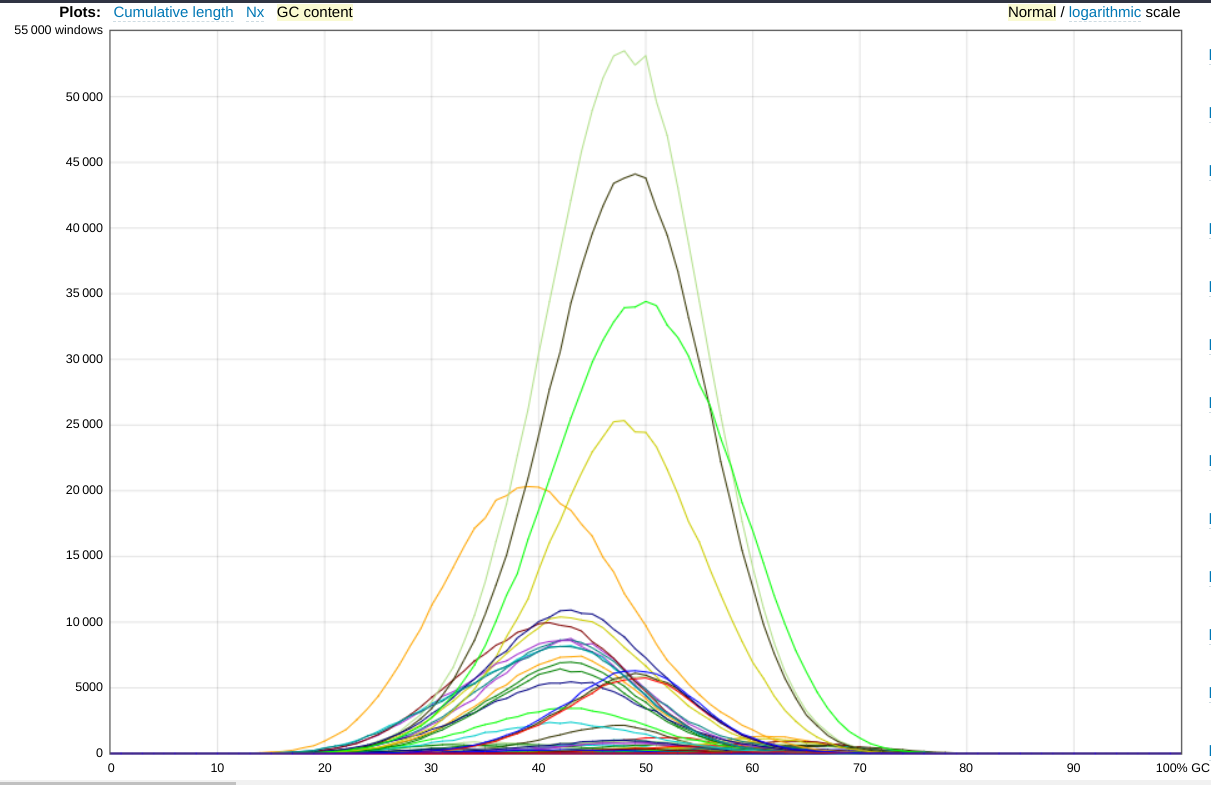

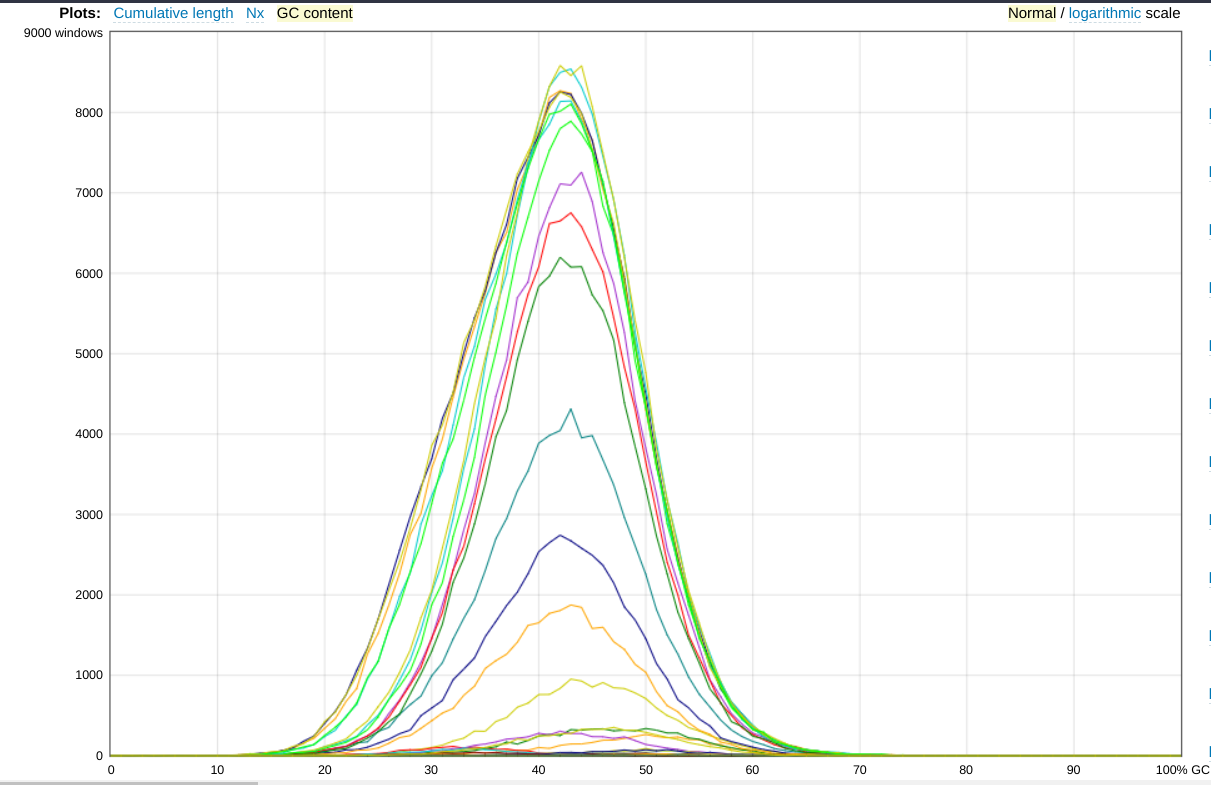

In [ ]:
### Step 14. Counting duplicates in BUSCOs

  C:97.6%[S:59.7%,D:37.9%],F:0.0%,M:2.4%,n:124     
  121  Complete BUSCOs (C)         
  74  Complete and single-copy BUSCOs (S)     
  47  Complete and duplicated BUSCOs (D)     
  0  Fragmented BUSCOs (F)         
  3  Missing BUSCOs (M)         
  124  Total BUSCO groups searched       

Assembly Statistics:
  2196  Number of scaffolds
  2638  Number of contigs
  16475702  Total length
  0.253%  Percent gaps
  24 KB  Scaffold N50
  15 KB  Contigs N50

In [ ]:
### Step 14. Mapping
import os


work_dir="/mnt/projects/thiomargarita/samples_data"
reference = "/mnt/projects/thiomargarita/reference/2926625205.fna"

stats_file = "/mnt/projects/thiomargarita/bwamem_stats.txt"
for sample_name in os.listdir(work_dir):
        bam_path = f"{work_dir}/{sample_name}/trimmed_reads_to_reference.bam"
        os.system(f"bwa mem {reference} -t 10"+\
                  f"{work_dir}/{sample_name}/{sample_name}_trim_1.fastq"+\
                  f"{work_dir}/{sample_name}/{sample_name}_trim_2.fastq | samtools view -Su - |"+\
                  f"samtools sort --threads 10 -m 2G -o {bam_path} -")
        with open(stats_file, 'a') as output:
                output.write(sample_name + '\n')
        os.system(f"bamtools stats -in {bam_path} | tee -a {stats_file}")